# Series representation of fBMs

## Editable constants

In [3]:
# Output settings (this affects the fBm plots; for intermediate plots, change the debugging settings).
save_graphs = True
show_graphs = True

# Final fBm simulation settings.
N = 2**10 # number of timepoints
T_0 = 0 # where to start (inclusive)
T_N = 1 # where to end (exclusive)
delta_H = 0.249 # distance between H's
resample_eps = True # whether to re-sample the epsilon_{j, k} between each H value

# Fourier transform approximation settings (used to calculate Psi_H from the Meyer wavelet psi). The
# formula for Psi_H(x) is an integral over R, but the integrand consists of multiplying another function
# by the Fourier Transform of the Meyer mother wavelet. This integrand decays rapidly for |xi| > 10, so
# it's okay to discretize it over a finite interval symmetric about zero.
M = 2**8 # size of the input vector to FFT (i.e. number of sample points for the input function)
delta_xi = 1 # step size

# Number of summands to take in the series approximation.
j_min = -2**3 # inclusive
j_max = 2**3 # exclusive
k_min = -2**3 # inclusive
k_max = 2**3 # exclusive

# Whether to run intermediate tests of individual functions (if True, plots are shown).
debug = True

# Floating point comparison settings (determine when errors/warnings are reported).
rtol = 1e-7 # relative (multiplicative) tolerance in float comparisons
atol = 1e-7 # absolute (additive) tolerance in float comparisons

## Remaining setup
Most users should not need to edit the file below this point.

In [4]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import numpy.random as random

In [5]:
delta_t = 2 * np.pi / (M * delta_xi)
t_0 = -delta_t * (M // 2)
xi = np.fft.fftfreq(M, delta_xi) * 2 * np.pi / delta_t

In [6]:
# Source: https://stackoverflow.com/questions/8924173/how-can-i-print-bold-text-in-python
class color:
   PURPLE = "\033[95m"
   CYAN = "\033[96m"
   DARKCYAN = "\033[36m"
   BLUE = "\033[94m"
   GREEN = "\033[92m"
   YELLOW = "\033[93m"
   RED = "\033[91m"
   BOLD = "\033[1m"
   UNDERLINE = "\033[4m"
   END = "\033[0m"

In [7]:
def warning(msg):
    print(color.YELLOW + color.BOLD + "WARNING: " + color.END + color.YELLOW + msg + color.END)

def error(msg):
    print(color.RED + color.BOLD + "ERROR: " + color.END + color.RED + msg + color.END)

def status(msg):
    print(color.GREEN + color.BOLD + "STATUS: " + color.END + color.GREEN + msg + color.END)

In [8]:
if debug:
    warning("warning messages look like this")
    error("error messages look like this")
    status("status messages look like this")

ERROR: error messages look like this
STATUS: status messages look like this


## Fourier Transform
Evaluate the Fourier Transform of $f$ on $\xi$: 
$$\hat{f}(\xi) = \frac{1}{\sqrt{2\pi}} \int_\mathbb{R} e^{-ix\xi} f(x) dx.$$
We interpret $f$ as a function on the time domain; taking the Fourier transform means we are evaluating it on the frequency domain, i.e. $\xi$ is a frequency.

This formula is not possible to compute via `scipy.integrate` for most input functions $f$. Instead, `numpy` built-ins support taking the Fast Fourier Transform (FFT) of a vector, so we implement a layer on top of this which approximates the Fourier Transform of $f$ on $\xi$ as above using a discretization of the integral.

In [9]:
def ft(f, xi):
    g = lambda x : np.exp(complex(0, -1) * x * xi) * f(x) # the integrand
    integral, err = integrate.quad(g, -np.inf, np.inf, complex_func=True)
    if not np.isclose(err, 0, atol=atol):
        warning("estimated error {} exceeds tolerance {}.".format(err, atol))
    return (2 * np.pi)**(-0.5) * integral

In [10]:
if debug:
    print(ft(np.sin, np.pi))

-1456.9157773697734j


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:448: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  im_retval = quad(imfunc, a, b, args, full_output, epsabs,


## Fast Fourier Transform (approximate)
$$\begin{align*}
\hat{f}(\xi)_k = \hat{f}(\xi_k) = \hat{f}(k \Delta \xi)
&\approx \frac{1}{\sqrt{2 \pi}} \sum_{m=1}^M \Delta t f (t_0 + m \Delta t) \exp(-ik \Delta \xi (t_0 + m \Delta t)) \\
&= \frac{1}{\sqrt{2 \pi}} \Delta t \exp(-i t_0 k \Delta \xi) \sum_{m=1}^M \exp \left(-2 \pi i \frac{mk}{M} \right) f(t_0 + m \Delta t) \\
&= \frac{1}{\sqrt{2 \pi}} \Delta t \exp(-i t_0 k \Delta \xi) DFT(f, t)_k \\
&= \phi_k DFT(f, t)_k
\end{align*}$$

where $\xi$ and $t$ are both zero-indexed length-$M$ vectors representing the discretized time and frequency domains.

The above expression demonstrates that the vector $\hat{f}(\xi)$ is the pointwise product of two vectors.

The bounds on $k$ come in at the last line when the expression is calculated using DFT; that output has length $M$.

In [11]:
# Source: https://stackoverflow.com/questions/24077913/discretized-continuous-fourier-transform-with-numpy

# Approximate the Fourier Transform of f, evaluated over the disretized frequency domain xi
def fast_ft(f):
    # Create the time samples that f must be evaluated on in order to compute its Fourier
    # Transform on xi using FFT: {t_0 + m * delta_t} for 1 <= m <= M
    t = np.arange(t_0 + delta_t, t_0 + (M + 1) * delta_t, delta_t)
    
    # Compute (discretized) Fourier Transform of f using numpy's FFT function; this is the
    # vector of DFT(f, t)_k's in the equation above
    g = np.fft.fft(f(t))

    # In order to get a discretization of the continuous Fourier transform, we multiply g
    # by a phase factor
    g *= delta_t * np.exp(complex(0, -1) * t_0 * xi) / np.sqrt(2 * np.pi)
    
    return g

/Users/chenxiaoran/Library/Python/3.10/lib/python/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


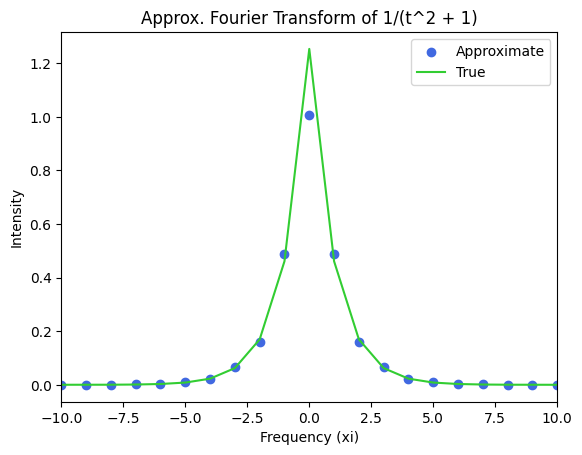

In [12]:
if debug:
    f = lambda t : 1. / (t**2 + 1.)
    g = fast_ft(f) # our version of f-hat
    h = np.exp(-np.abs(xi)) * np.sqrt(np.pi / 2) # true version of f-hat
    
    _, ys = zip(*sorted(zip(xi, g)))
    xs, zs = zip(*sorted(zip(xi, h)))
    
    plt.scatter(xs, ys, color="royalblue", label="Approximate")
    plt.plot(xs, zs, color="limegreen", label="True")
    
    plt.title("Approx. Fourier Transform of 1/(t^2 + 1)")
    plt.xlabel("Frequency (xi)")
    plt.ylabel("Intensity")
    
    plt.gca().set_xlim(-10,10)
    plt.legend()
    plt.show()

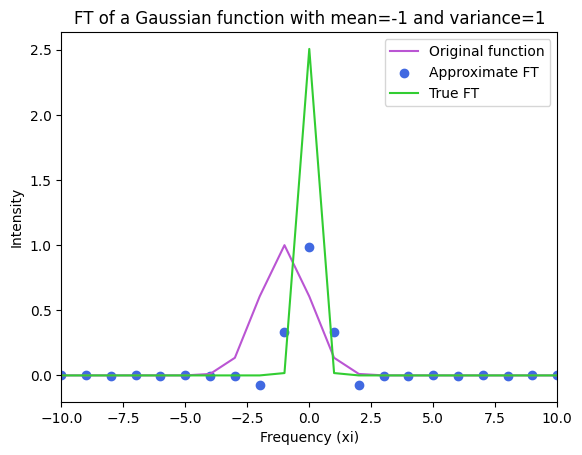

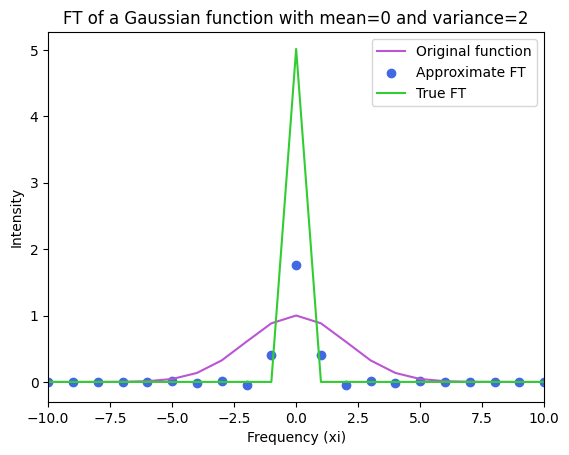

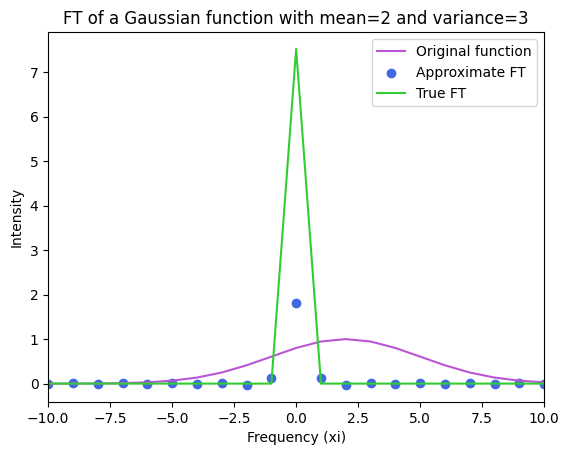

In [13]:
if debug:
    gaussian = lambda x, mu, sig : np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    specific_gaussian = lambda mu, sig : lambda x : gaussian(x, mu, sig) # f
    for mu, sig in [(-1, 1), (0, 2), (2, 3)]:
        f = specific_gaussian(mu, sig)(xi) # discretized f
        g = fast_ft(specific_gaussian(mu, sig)) # our version of f-hat
        h = np.sqrt(2 * np.pi * sig**2) * specific_gaussian(0, 1 / (np.pi * sig))(xi) # true version of f-hat

        _, fs = zip(*sorted(zip(xi, f)))
        _, gs = zip(*sorted(zip(xi, g)))
        xs, hs = zip(*sorted(zip(xi, h)))

        plt.plot(xs, fs, color="mediumorchid", label="Original function")
        plt.scatter(xs, gs, color="royalblue", label="Approximate FT")
        plt.plot(xs, hs, color="limegreen", label="True FT")
        
        plt.title("FT of a Gaussian function with mean={} and variance={}".format(mu, sig))
        plt.xlabel("Frequency (xi)")
        plt.ylabel("Intensity")
        
        plt.gca().set_xlim(-10,10)
        plt.legend()
        plt.show()
        plt.close()

## Meyer mother wavelet
Evaluate the Meyer mother wavelet $\psi$ on $t$ in the time domain:
$$\psi = \psi_1 + \psi_2$$
where
$$\psi_1(t) = \frac{\frac{4}{3\pi} \left(t - \frac{1}{2}\right) \cos\left[\frac{2\pi}{3} \left(t - \frac{1}{2}\right)\right] - \frac{1}{\pi} \sin\left[\frac{4\pi}{3} \left(t - \frac{1}{2}\right)\right]}{\left(t - \frac{1}{2}\right) - \frac{16}{9}\left(t - \frac{1}{2}\right)^3}$$
and
$$\psi_2(t) = \frac{\frac{8}{3\pi} \left(t - \frac{1}{2}\right) \cos\left[\frac{8\pi}{3} \left(t - \frac{1}{2}\right)\right] + \frac{1}{\pi} \sin\left[\frac{4\pi}{3} \left(t - \frac{1}{2}\right)\right]}{\left(t - \frac{1}{2}\right) - \frac{64}{9}\left(t - \frac{1}{2}\right)^3}.$$

Source: [Valenzuela and de Oliveira, 2015](https://arxiv.org/abs/1502.00161)

In [14]:
def psi_1(t):
    num = 4 / (3 * np.pi) * (t - 0.5) * np.cos((2 * np.pi / 3) * (t - 0.5))
    num -= np.sin((4 * np.pi / 3) * (t - 0.5)) / np.pi
    denom = (t - 0.5) - (16 / 9) * (t - 0.5)**3
    return num/denom

In [15]:
def psi_2(t):
    num = 8 / (3 * np.pi) * (t - 0.5) * np.cos((8 * np.pi / 3) * (t - 0.5))
    num += np.sin((4 * np.pi / 3) * (t - 0.5)) / np.pi
    denom = (t - 0.5) - (64 / 9) * (t - 0.5)**3
    return num/denom

In [16]:
def meyer(t):
    return psi_1(t) + psi_2(t)

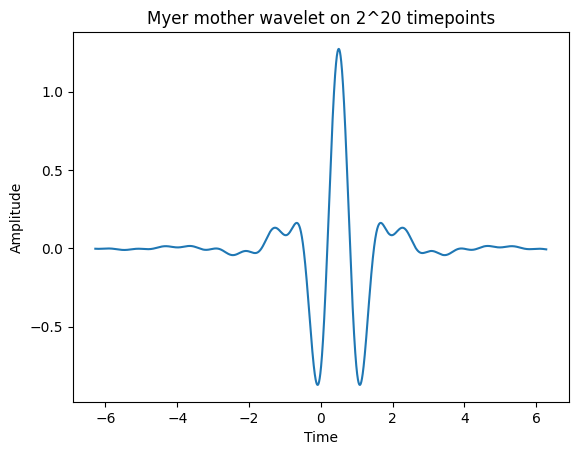

In [17]:
if debug:
    q = 20 # 2**q timepoints are sampled
    x_vals = np.linspace(-2*np.pi, 2*np.pi, num=2**q, endpoint=True)
    y_vals = meyer(x_vals)
    
    plt.plot(x_vals, y_vals)
    
    plt.title("Myer mother wavelet on 2^{} timepoints".format(q))
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    
    plt.show()
    plt.close()

## Left-sided fractional primitives of the Meyer mother wavelet
Evaluate $\Psi_H$ on $x$, where $\Psi_H$ is the left-sided fractional primitive of order $H + 1/2$ of $\psi$ and $\psi$ is a Meyer mother wavelet:
$$\Psi_H(x) = \int_\mathbb{R} e^{ix\xi}\frac{\hat{\psi}(\xi)}{(i\xi)^{H+1/2}}d\xi.$$
The index $H$ is in $(0, 1)$.

In [18]:
# currently, x has to be a scalar
def Psi_H(H, x):
    g = np.exp(complex(0, 1) * x * xi) * fast_ft(meyer)
    xi_divisible = np.array([rtol if i == 0 else i for i in xi])
    g /= (complex(0, 1) * xi_divisible)**(H + 0.5)
    return integrate.simpson(g, xi)

/Users/chenxiaoran/Library/Python/3.10/lib/python/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


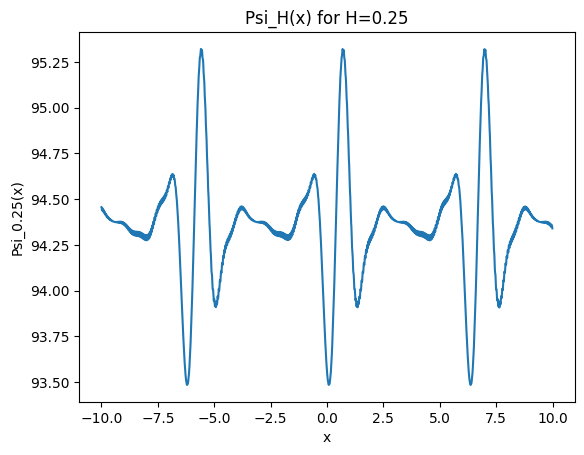

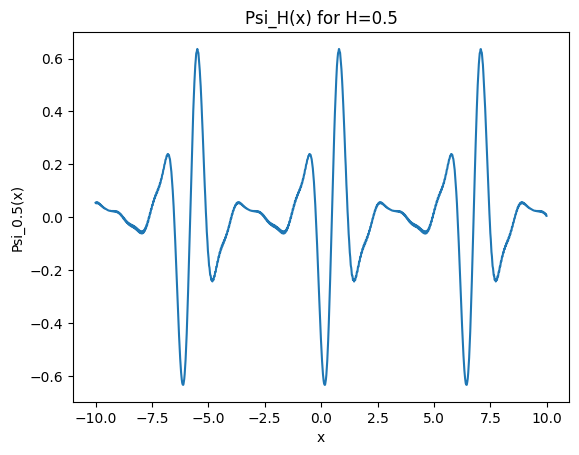

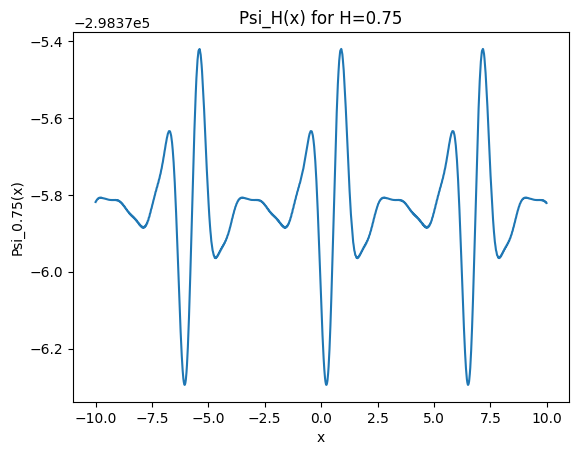

In [19]:
if debug:
    d = 0.25
    for H in np.arange(d, 1, d):
        xs = np.arange(-10, 10, 0.01)
        ys = np.array([Psi_H(H, x) for x in xs])
        plt.plot(xs, ys, label="H={}".format(H))

        plt.title("Psi_H(x) for H={}".format(H))
        plt.xlabel("x")
        plt.ylabel("Psi_{}(x)".format(H))
        
        plt.show()

## Plotting utility

In [20]:
# Plot all the fBms next to each other (vertically)
def plot(Hs, Ns, Ts, fBms):
    assert(len(Hs) == len(Ns) and len(Ns) == len(Ts) and len(Ts) == len(fBms))
    numrows = len(Ns)
    fig, axs = plt.subplots(numrows, 1, figsize=(14, 6*numrows), sharex=True)
    
    for n in range(numrows):
        axs[n].plot(Ts[n], fBms[n], label="H={:.2f}, N={}".format(Hs[n], Ns[n]))
        axs[n].legend(fontsize = 18)

    fig.suptitle("Paths of fBm for different values of H", fontsize=24)
    fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.95, bottom=0.05)

    for ax in axs.flat:
        ax.set_xlabel("Time (over the unit interval)", fontsize=18)
        ax.set_ylabel("Particle position", fontsize=18)
    for ax in axs.flat:
        ax.label_outer()
    
    if save_graphs:
        plt.savefig("fBm-series-rep.png")

    if show_graphs:
        plt.show()

## Series representation
Evaluate the series representation:

$$B_H(t) = \sum_{j \in \mathbb{Z}} \sum_{k \in \mathbb{Z}} 2^{-jH} \varepsilon_{j, k} \left(\Psi_H \left(2^j t - k\right) - \Psi_H \left(-k\right)\right)$$

over a $(j_{max} - j_{min}) \times (k_{max} - k_{min})$ grid of summands:

$$B_H(t) = \sum_{j = j_{min}}^{j_{max} - 1} \sum_{k = k_{min}}^{k_{max} - 1} 2^{-jH} \varepsilon_{j, k} \left(\Psi_H \left(2^j t - k\right) - \Psi_H \left(-k\right)\right)$$

where the $\varepsilon_{j, k}$ are all i.i.d. standard normals.

In [21]:
def epsilons():
    return random.standard_normal((j_max - j_min, k_max - k_min))

In [22]:
# currently, t has to be a scalar
def B_H(H, t, eps):
    sum = 0
    for k in range(k_min, k_max):
        cons_k = Psi_H(H, -k)
        for j in range(j_min, j_max):
            sum += 2**(-j * H) * eps[j - j_min][k - k_min] * (Psi_H(H, 2**j * t - k) - cons_k)
    return sum

In [23]:
def simulate_all():
    Hs = np.arange(delta_H, 1, delta_H) # H : float in (0, 1)
    
    n = len(Hs) # number of trials
    Ns = np.full((n, ), N) # for now we won't vary this parameter
    ts = np.arange(T_0, T_N, (T_N - T_0) / N)
    Ts = np.array([ts for k in range(n)])
    
    fBms = np.empty((n, N, ))

    for k in range(n):
        H = Hs[k]
        assert(0 < H and H < 1 and type(N) is int and 0 < N)
        
        eps = epsilons()
        fBms[k] = np.array([B_H(H, t, eps) for t in Ts[k]]) # simulate(N, M, H)

    return Hs, Ns, Ts, fBms

## Generate output

/var/folders/8y/3c251v6s30g9t4vwff__270m0000gn/T/ipykernel_93464/1664599322.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  fBms[k] = np.array([B_H(H, t, eps) for t in Ts[k]]) # simulate(N, M, H)


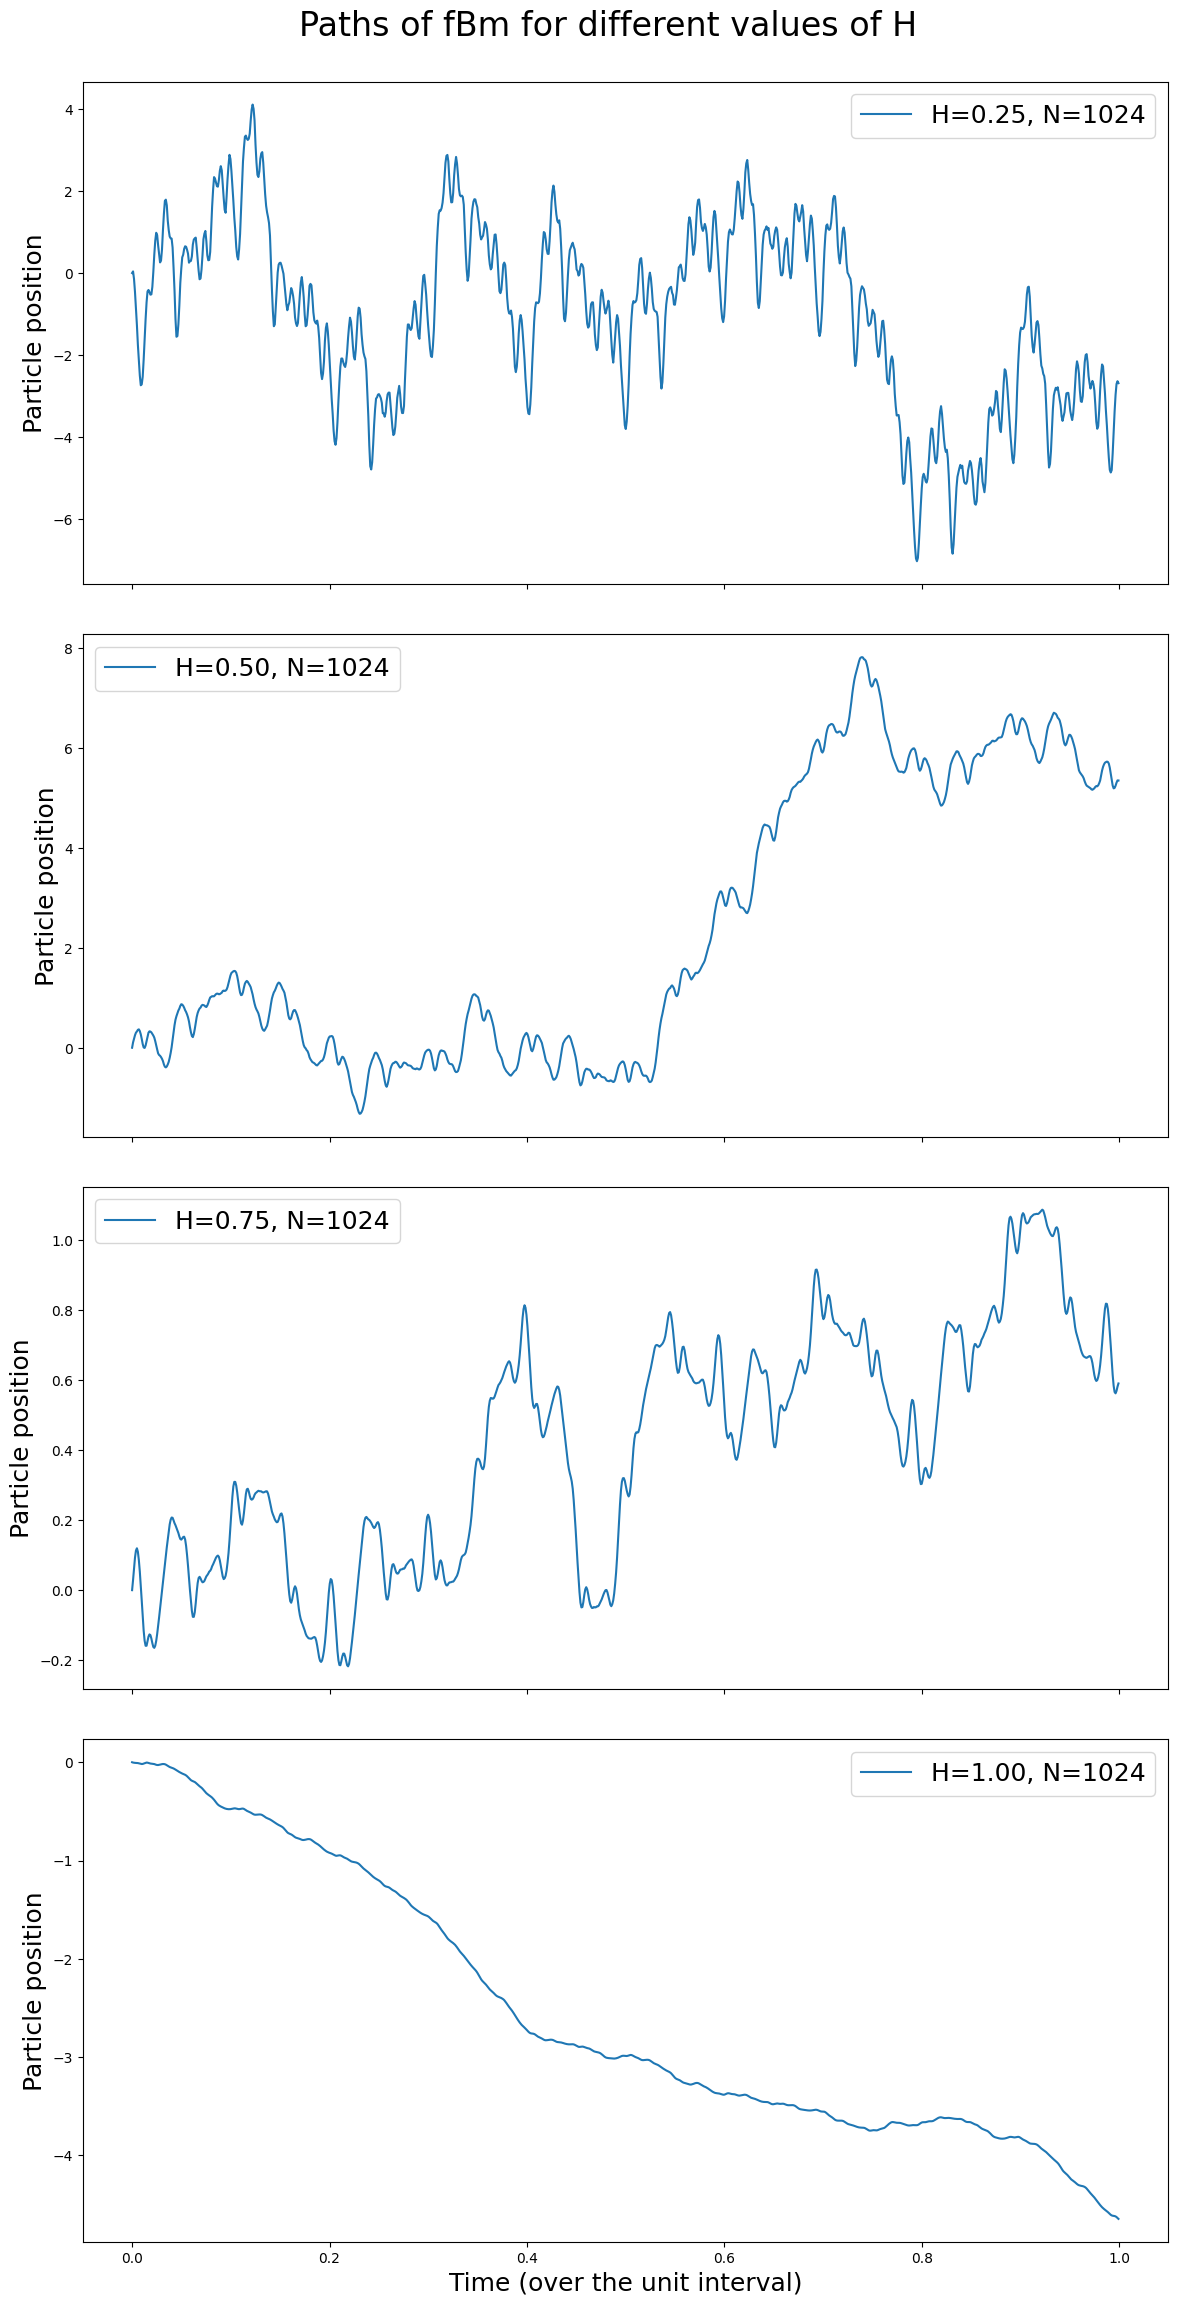

In [24]:
Hs, Ns, Ts, fBms = simulate_all()

if show_graphs or save_graphs:
    plot(Hs, Ns, Ts, fBms)

# Workspace

## Understanding `scipy.integrate`

In [25]:
integrate.quad(np.sin, -np.inf, np.inf)

(0.0, 0.0)

In [26]:
random.standard_normal((2, 2))

array([[ 0.03074452, -1.9215172 ],
       [ 0.48397655, -0.97348898]])

## Understanding the PyWavelets implementation of the discrete Meyer mother wavelet

We didn't use this builtin because it comes with a fixed discretized domain over which it can be evaluated. Since a relatively simple (made up of trig functions and low-order polynomials) closed form exists and we wanted to be able to control how Psi_H was approximated, we chose to calculate the Meyer mother wavelet ourselves. However, this library is a quick and easy way to visualize some Meyer wavelets and double-check that our own computation looks reasonable.

In [27]:
pywt.wavelist('dmey')

['dmey']

Wavelet dmey
  Family name:    Discrete Meyer (FIR Approximation)
  Short name:     dmey
  Filters length: 62
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       symmetric
  DWT:            True
  CWT:            False


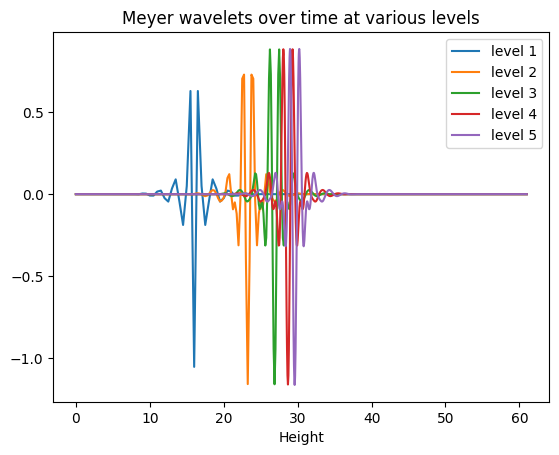

In [28]:
wavelet = pywt.Wavelet('dmey')
print(wavelet)

for level in range(1, 6):
    phi, psi, x_vals = wavelet.wavefun(level=level)
    plt.plot(x_vals, psi, label="level {}".format(level))
    
plt.title("Meyer wavelets over time at various levels")
plt.xlabel("Time")
plt.xlabel("Height")
plt.legend()

plt.show()